In [1]:
# If a single TARGETID only differs by SGA_ID, then it must mean that one galaxy lies behind another and both are in the field of view. 
# However, does that mean one has false data? given that a single Z is showing for both?

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import warnings

from astropy.io import fits
from astropy.table import join, Table, QTable, unique, Column, vstack, hstack, join, setdiff
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy import constants
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.utils.data import get_pkg_data_filename
from tqdm.notebook import tqdm_notebook
 
from scipy.optimize import minimize

In [3]:
mpl.rc('font', size=12)
mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

In [4]:
h = 1

H0 = 100*h

c = constants.c.to('km/s')
    
q0 = 0.2

Read in PV Targets

In [5]:
# Currently using the non-filtered FUJI data
PV_filename = "/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits"

hdu = fits.open(PV_filename)
PV_obs = QTable(hdu[1].data)
hdu.close()

Clean data of duplicates

In [6]:
# There are some TARGETIDs that have the exact same values everywhere but the PVTYPE e.g. 

PV_obs[PV_obs['TARGETID']==1070084336386050]

# TFT = Tully Fisher Target ... EXT = Extended targets
# Check to make sure that all TFT at 0.4R also exist as a EXT. 

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64
1070084336386050,212.91403599788,-1.20264591149526,25918,sv3,1.30040281582228,0.000201069616666526,4,1.83105237782001,fuji/healpix/sv3/bright/259/25918/redrock-sv3-bright-25918.fits,EXT,975775,212.91403599788003,-1.2026459114952552
1070084336386050,212.91403599788,-1.20264591149526,25918,sv3,1.30040281582228,0.000201069616666526,4,1.83105237782001,fuji/healpix/sv3/bright/259/25918/redrock-sv3-bright-25918.fits,TFT,975775,212.91403599788003,-1.2026459114952552


In [7]:
PV_obs

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


In [8]:
def count_duplicates(data):
    """
    * Counts the number of duplicate TARGETIDs
    * Separates the TARGETIDs that differ in something other than PVTYPE and those that do not. 
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    same: Table of all TARGETIDs that only differ by PVTYPE.
    not-same: Table of all TARGETIDs that differ somewhere other than just PVTYPE.
    """
    # Shows how many TARGETIDs correlate to more than one row in the PV_observed table
    data_tf = None
    duplicate_targets = None
    length = 0
    for targetid in np.unique(data['TARGETID']):
        PV_target = data[data['TARGETID']==targetid]
        len_PV = len(PV_target)
        if len_PV > 1 :
            length += 1
            if duplicate_targets is None:
                duplicate_targets= PV_target
            else:
                duplicate_targets = vstack([duplicate_targets, PV_target])
        else:
            # Here I'm creating a table of all data that do not have duplicate TARGETIDs
            #if data_tf is None:
            #data_tf = PV_target
            #else:
            #    data_tf = vstack([data_tf, PV_target])
            pass
    
    print(f"Number of duplicate TARGETIDs: {length}")

    # Checking if all TARGETIDs have the same values except PVTYPE. If True, included in same. If False, included in not_same. 

    columns = ['TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'SGA_ID', 'RA', 'DEC']
    not_same = None
    same = None

    for targetid in np.unique(duplicate_targets["TARGETID"]):
        bet = 0 
        PV_target = duplicate_targets[duplicate_targets['TARGETID'] == targetid]
        for column in columns:
            if PV_target[0][column] == PV_target[1][column]:
                bet += 1
                continue
            else: 
                # Here I'm adding to data_tf the duplicate_targets that actually differ somewhere other than PVTYPE.
                #if data_tf is None:
                #    data_tf = PV_target
                #else:
                #    data_tf = vstack([data_tf, PV_target])
                if not_same is None:
                    not_same = PV_target
                else:
                    not_same = vstack([not_same, PV_target])
                break
        if bet == 11:
            if same is None:
                same = PV_target
            else:
                same = vstack([same, PV_target])
        else:
            continue
    
    print(f"Number of duplicate TARGETIDs that differ in value in a column other than PVTYPE: {len(not_same)/2}")
    print(f"Number of duplicate TARGETIDs that are the same other than PVTYPE: {len(same)/2}")
    print(f"Number of TARGETIDs with PVTYPE EXT: {len(same[same['PVTYPE']=='EXT'])}")
    print(f"Number of TARGETIDs with PVTYPE TFT: {len(same[same['PVTYPE']=='TFT'])}")

    return same, not_same

In [9]:
same, not_same = count_duplicates(PV_obs)

Number of duplicate TARGETIDs: 175
Number of duplicate TARGETIDs that differ in value in a column other than PVTYPE: 105.0
Number of duplicate TARGETIDs that are the same other than PVTYPE: 70.0
Number of TARGETIDs with PVTYPE EXT: 70
Number of TARGETIDs with PVTYPE TFT: 70


In [10]:
PV_observed = unique(PV_obs, keys=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'SGA_ID', 'RA', 'DEC'], keep= 'first')
print("All iterations where only PVTYPE differs, EXT shows up first in table than TFT for a given TARGETID. Therefore keep = 'first'."
      f"\nTotal number of rows before cut: {len(PV_obs)}"
      f"\nTotal number of rows after cut: {len(PV_observed)}"
      f"\nTotal number of rows removed = {len(PV_obs)-len(PV_observed)}")

All iterations where only PVTYPE differs, EXT shows up first in table than TFT for a given TARGETID. Therefore keep = 'first'.
Total number of rows before cut: 13134
Total number of rows after cut: 13064
Total number of rows removed = 70


In [11]:
not_same[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64
1070102522888196,216.979688742175,-0.561009480538136,25955,sv3,0.0791824158558448,1.18648953694193e-05,0,1942.84309843928,fuji/healpix/sv3/bright/259/25955/redrock-sv3-bright-25955.fits,TFT,482276,216.97968874217543,-0.5610094805381362
1070102522888196,216.979688742175,-0.561009480538136,25955,sv3,0.0791824158558448,1.18648953694193e-05,0,1942.84309843928,fuji/healpix/sv3/bright/259/25955/redrock-sv3-bright-25955.fits,TFT,25383,216.97962864217408,-0.561024095127635
1070193119854601,217.273846767534,3.14929387412025,26065,sv3,0.00594845314800224,9.42523772068482e-06,0,244.997579371964,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,EXT,1187049,217.27384676753445,3.1492938741202536
1070193119854601,217.273846767534,3.14929387412025,26065,sv3,0.00594845314800224,9.42523772068482e-06,0,244.997579371964,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,TFT,1187049,217.27384676753445,3.149293874120253
1070193124048897,217.49870031729,3.24248326779518,26065,sv3,1.08064886152119,0.000130994611665261,4,3.34225494042039,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,EXT,1049438,217.49870031728966,3.2424832677951803


In [12]:
unique(not_same[:5], keep = "none")

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64
1070102522888196,216.979688742175,-0.561009480538136,25955,sv3,0.0791824158558448,1.18648953694193e-05,0,1942.84309843928,fuji/healpix/sv3/bright/259/25955/redrock-sv3-bright-25955.fits,TFT,25383,216.97962864217408,-0.561024095127635
1070102522888196,216.979688742175,-0.561009480538136,25955,sv3,0.0791824158558448,1.18648953694193e-05,0,1942.84309843928,fuji/healpix/sv3/bright/259/25955/redrock-sv3-bright-25955.fits,TFT,482276,216.97968874217543,-0.5610094805381362
1070193119854601,217.273846767534,3.14929387412025,26065,sv3,0.00594845314800224,9.42523772068482e-06,0,244.997579371964,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,EXT,1187049,217.27384676753445,3.1492938741202536
1070193119854601,217.273846767534,3.14929387412025,26065,sv3,0.00594845314800224,9.42523772068482e-06,0,244.997579371964,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,TFT,1187049,217.27384676753445,3.149293874120253
1070193124048897,217.49870031729,3.24248326779518,26065,sv3,1.08064886152119,0.000130994611665261,4,3.34225494042039,fuji/healpix/sv3/bright/260/26065/redrock-sv3-bright-26065.fits,EXT,1049438,217.49870031728966,3.2424832677951803


In [13]:
PV_observed[PV_observed['TARGETID']==1070072240013322]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64
1070072240013322,211.959006708595,-1.65473654112272,25915,sv3,0.054200428204072,8.38051441842955e-05,0,240.291921200405,fuji/healpix/sv3/bright/259/25915/redrock-sv3-bright-25915.fits,TFT,90791,211.9590067085955,-1.654736541122716


In [14]:
# Not sure why this isn't working? Each table is coming out as "None". I'm hoping this will separate the table differences into each separate column table. 
'''
columns = ['TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'SGA_ID', 'RA', 'DEC']
target_ra_table, target_dec_table, healpix_table, survey_table, z_table = None, None, None, None, None
zerr_table, zwarn_table, deltachi2_table, sgaid_table, ra_table, dec_table = None, None, None, None, None, None

col_tables = [target_ra_table, target_dec_table, healpix_table, survey_table, z_table,
             zerr_table, zwarn_table, deltachi2_table, sgaid_table, ra_table, dec_table]
i = 0
for column in columns:
    unique_cols = columns[:]
    unique_cols.remove(column)
    table_2 = unique(PV_obs, keys= unique_cols, keep= 'none')
    col_tables[i] = setdiff(PV_obs, table_2)
    i+=1
    print(col_tables[i])
'''


"\ncolumns = ['TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'SGA_ID', 'RA', 'DEC']\ntarget_ra_table, target_dec_table, healpix_table, survey_table, z_table = None, None, None, None, None\nzerr_table, zwarn_table, deltachi2_table, sgaid_table, ra_table, dec_table = None, None, None, None, None, None\n\ncol_tables = [target_ra_table, target_dec_table, healpix_table, survey_table, z_table,\n             zerr_table, zwarn_table, deltachi2_table, sgaid_table, ra_table, dec_table]\ni = 0\nfor column in columns:\n    unique_cols = columns[:]\n    unique_cols.remove(column)\n    table_2 = unique(PV_obs, keys= unique_cols, keep= 'none')\n    col_tables[i] = setdiff(PV_obs, table_2)\n    i+=1\n    print(col_tables[i])\n"

Read in SGA Catalog

In [15]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

In [16]:
#Adding a column for radius rather than constantly using diameter.
col_c = Column(name = "R26", data = SGA["D26"]/2)
SGA.add_column(col_c)

In [17]:
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,R26
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0,0.24735287
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0

Create a dictionary where each key is a given SGA_ID and it outputs the index for the given ID in the catalog

In [18]:
#Remove all unnecessary data to find only unique SGA IDs
PV_unique_SGA_ID = unique(PV_observed, keys = 'SGA_ID')

In [19]:
#This only needs to be run once to create the dictionary from the SGA catalog.

SGA_dictionary = {}

for i in range(len(PV_unique_SGA_ID["SGA_ID"])):
    SGA_dictionary[PV_unique_SGA_ID[i]["SGA_ID"]] = SGA[SGA["SGA_ID"] == PV_unique_SGA_ID[i]["SGA_ID"]]
    

In [20]:
PV_observed["TARGET_RA","TARGET_DEC","RA","DEC"][PV_observed['SGA_ID']==1583]

TARGET_RA,TARGET_DEC,RA,DEC
float64,float64,float64,float64
236.810202992035,43.9950609278788,236.81020299203462,43.99506092787884
236.813448650733,43.9957553864163,236.8134486507333,43.99575538641631
236.815120686376,43.9961131019287,236.81512068637608,43.99611310192875
236.816743563778,43.9964602730794,236.8167435637778,43.996460273079435
236.813448650733,43.9957553864163,236.8134486507333,43.99575538641631
236.811825811888,43.9954081686317,236.81182581188813,43.995408168631656


Add distance and rotational velocity columns to the data. 

In [21]:
# Is this how inclincation angle is dealt with?
V_OBS = 5
b = 3
a = 5
theta = np.arccos(b/a)
V_ROT = V_OBS/np.sin(theta)
V_ROT

6.25

In [22]:
# Which one is the ACTUAL RA & DEC for the fiber? RA & DEC or TARGET_RA & TARGET_DEC in PV_observed? 
# Currently using RA & DEC

def distance(data):
    """
    * Creates two new columns dependent on distance. 
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    Original astropy.Table with additional columns:
    SKY_TARGET_DIST: True distance from center to TARGETID position
    SKY_TARGET_DIST_R26: Distance from center in units of radii
    
    """
    data['SKY_TARGET_DIST'] = 0.
    data['SKY_TARGET_DIST_R26'] = 0.

    # For each SGA galaxy that has at least one observation, calculate the distance
    # for all of that galaxy's targets
    
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)
            
            # Find galaxy info from dictionary
            galaxy = SGA_dictionary[sga_gal]

            # Identify all galaxy targets on this galaxy
            obs_idx = data['SGA_ID'] == sga_gal

            # Calculate distance between each target and the center
            center_coords = SkyCoord(ra=galaxy['RA'], dec=galaxy['DEC'], unit=u.degree)
            target_coords = SkyCoord(ra=data['TARGET_RA'][obs_idx], dec=data['TARGET_DEC'][obs_idx], unit=u.degree)

            sep2d = target_coords.separation(center_coords)

            data['SKY_TARGET_DIST'][obs_idx] = sep2d
            data['SKY_TARGET_DIST_R26'][obs_idx] = sep2d.to('arcmin')/galaxy['R26']*u.arcmin

    return data

    
def rot_vel(data):
    """
    * Creates two new columns dependent on Z 
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    Original astropy.Table with additional columns:
    V_ROT: Rotational velocity of TARGET
    V_ROT_ERR: Error associated with rotational velocity of TARGET
    
    """
    
    data['V_ROT'] = np.nan
    data['V_ROT_ERR'] = np.nan

    # Identify all observations that are on galaxy centers
    centers_idx = (data['TARGETID'] > 30000000000000000) & (data['TARGETID'] < 40000000000000000)
    
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)

            # Identify all galaxy targets on this galaxy
            obs_idx = data['SGA_ID'] == sga_gal

            # Identify the center observation(s) of this galaxy
            center_idx = centers_idx & obs_idx

            if np.sum(center_idx) > 0:

                # Use the average redshift of all center observations for the systemic velocity
                z_center = np.mean(data['Z'][center_idx])
                z_err_center2 = np.mean(data['ZERR'][center_idx]**2)/np.sum(center_idx)

                # Calculate rotational velocity for all observations of the galaxy
                data['V_ROT'][obs_idx] = c*(data['Z'][obs_idx] - z_center)
                data['V_ROT_ERR'][obs_idx] = c*np.sqrt(data['ZERR'][obs_idx]**2 + z_err_center2)
    
    return data

# Do I want to use BA or BA LEDA?
# Currently using BA

def inclination_corrected(data):
    """
    * Corrects the V_ROT for inclination angle
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    Original astropy.Table with additional column:
    V_ROT_CORRECTED: Rotational velocity with corrected values. 
    V_ROT_CORRECTED_ERR: Corrected rotational velcoity error.
    
    """
    
    data['V_ROT_CORRECTED'] = np.nan
    data['V_ROT_CORRECTED_ERR'] = np.nan

    # Setup for progress bar
    N = len(data)

    with tqdm_notebook(total=N) as progress_bar:
        for i in range(len(data)):
            progress_bar.update(1)
            
            PV_target = data[i]
            sga_gal = PV_target['SGA_ID']

            # Accounting for inclination angle
            theta = np.arccos(SGA_dictionary[sga_gal]['BA'])

            if theta == 0:
                PV_target['V_ROT_CORRECTED'] = PV_target['V_ROT']
                PV_target['V_ROT_CORRECTED_ERR'] = PV_target['V_ROT_ERR']
            else: 
                PV_target['V_ROT_CORRECTED'] = PV_target['V_ROT']/np.sin(theta)
                PV_target['V_ROT_CORRECTED_ERR'] = PV_target['V_ROT_ERR']/np.sin(theta)

    return data

In [23]:
PV_observed = distance(PV_observed)
PV_observed = rot_vel(PV_observed)
PV_observed = inclination_corrected(PV_observed)

  0%|          | 0/4524 [00:00<?, ?it/s]

  0%|          | 0/4524 [00:00<?, ?it/s]

  0%|          | 0/13064 [00:00<?, ?it/s]

In [24]:
PV_observed[PV_observed['SGA_ID']==1583]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_TARGET_DIST,SKY_TARGET_DIST_R26,V_ROT,V_ROT_ERR,V_ROT_CORRECTED,V_ROT_CORRECTED_ERR
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64
1071077795037186,236.810202992035,43.9950609278788,9923,sv3,0.0356212945166845,2.64003527378348e-05,0,36.7676933435723,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81020299203462,43.99506092787884,0.0012179991249324554,0.3300000065694801,45.1744338975044,8.135065572496423,60.80552673339844,10.949932098388672
1071077795037187,236.813448650733,43.9957553864163,9923,sv3,0.0352887795291414,7.31620291911626e-06,0,550.152345106006,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.8134486507333,43.99575538641631,0.0012179991249659627,0.33000000657855844,-54.511051539881485,2.889416577693099,-73.37276458740234,3.889202117919922
1071077795037188,236.815120686376,43.9961131019287,9923,sv3,1.51232579748677,0.000144175642625962,4,0.879315532743931,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81512068637608,43.99611310192875,0.0024729073147124725,0.6700000134614925,442750.04711896775,43.26367816395112,595948.8125,58.233619689941406
1071077795037189,236.816743563778,43.9964602730794,9923,sv3,0.637227019154047,7.5017431284708e-05,4,3.39603114128113,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.8167435637778,43.996460273079435,0.003690906440145128,1.000000020166495,180402.03336980354,22.568180902274428,242824.078125,30.377138137817383
1084271934570499,236.813448650733,43.9957553864163,9923,sv3,0.0353008322684175,9.4825361822116e-06,0,335.291149647906,fuji/healpix/sv3/dark/99/9923/redrock-sv3-dark-9923.fits,TFT,1583,236.8134486507333,43.99575538641631,0.0012179991249659627,0.33000000657855844,-50.89773120666509,3.4087311574421326,-68.5091781616211,4.588207721710205
39633149604397504,236.811825811888,43.9954081686317,9923,sv3,0.0354706088249934,6.27417750722545e-06,0,869.667408287525,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81182581188813,43.995408168631656,7.770842496908934e-14,2.1054022310340753e-11,0.0,2.660066551282587,0.0,3.580493211746216


Filter data with quality control cuts. Currently 3 different methods. Clean catalog, qual control & qual control clean catalog.

In [25]:
# Testing Idea
V_OBS = 5
b = 3
a = 5
theta = np.arccos(b/a)
V_ROT = V_OBS/np.sin(theta)
V_ROT

6.25

In [26]:
def firstdigit(n):
    """
    * Return the first digit of a number
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    return np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


def separate(data, arms_isgoodz = False):
    """
    * Separates the data for center observations and non-center observations
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25) for center observations always
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25) for non-center observations if arms_isgoodz = True
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    centers: All center observations with only good redshifts
    arms: All non-center observations. Depending on arms_isgoodz, redshift may be checked. 
    """
    
    centers_idx = (data['TARGETID'] > 30000000000000000) & (data['TARGETID'] < 40000000000000000)
    
    # Identify targets with good redshifts.
    isgoodz = (data['ZWARN']==0) & (data['DELTACHI2']>=25) & centers_idx
    
    centers = data[isgoodz]
    
    # Arms of galaxies
    arms = data[~centers_idx] #~ causes the opposite effect for boolean
    
    if arms_isgoodz is True:
        
        isgoodz_arms = (data['ZWARN']==0) & (data['DELTACHI2']>=25) & ~centers_idx
        arms = data[isgoodz_arms]

    return centers, arms


def clean_catalog(data):
    """
    Take a catalog and apply quality cuts:
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25)
    * Ensure 1 main DESI TARGETID per SGA_ID
    * Ensure >2 non-main distinct TARGETIDs per SGA_ID at different radii
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for analysis, after quality cuts.
    """
    # All targets
    _ids_all, _counts_all = np.unique(data['SGA_ID'], return_counts=True)

    # Identify targets with good redshifts.
    isgoodz = (data['ZWARN']==0) & (data['DELTACHI2']>=25)
    _ids_goodz, _counts_goodz = np.unique(data['SGA_ID'][isgoodz], return_counts=True)

    # Select SGA_IDs with at least 2 good associated redshifts.
    select = np.in1d(data['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
    data = data[select].group_by('SGA_ID')

    # Storage for output.
    data_tf = None

    # Setup for progress bar
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)
    
    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate(sga_ids):
            progress_bar.update(1)
            tab = data[data['SGA_ID']==sga_id]

            # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
            digits = firstdigit(tab['TARGETID'])
            
            if np.any(digits == 3):
                
                # Do we have observation at at least 2 different radii?
                num_0p3 = np.sum((tab['SKY_TARGET_DIST_R26'] > 0.3) & (tab['SKY_TARGET_DIST_R26'] < 0.35))

                num_0p6 = np.sum((tab['SKY_TARGET_DIST_R26'] > 0.6) & (tab['SKY_TARGET_DIST_R26'] < 0.7))

                num_1 = np.sum(tab['SKY_TARGET_DIST_R26'] > 0.95)

                check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]
                if sum(check) > 1:
                    if data_tf is None:                                                                                                                
                        data_tf = tab
                    else:
                        data_tf = vstack([data_tf, tab])
                else:
                    continue
            else:
                continue

    return data_tf


def qual_control(data):
    """
    Take a catalog and apply quality cuts:
    * Ensure 1 main DESI TARGETID per SGA_ID with good redshift
    * non_main TARGETIDs must have V_ROT < 1000km/s
    * Ensure >2 non-main TARGETIDs per SGA_ID at different radii
    * Does not check if off-center TARGETIDs have good redshift
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for analysis, after quality cuts.
    """

    # Storage for output.
    data_tf = None
    
    # Setup for progress bar
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate(sga_ids):
            progress_bar.update(1)
            
            tab = PV_observed[data['SGA_ID'] == sga_id]

            # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
            digits = firstdigit(tab['TARGETID'])

            if np.any(digits == 3):

                # Separating the data. arms_isgoodz = False. Only want centers checked for good z. 
                centers, arms = separate(tab, arms_isgoodz = False)

                if len(centers) >0:

                    # Do we have a good observation at at least 2 different radii?
                    good_bool = np.abs(arms['V_ROT']) < 1000#*u.km/u.s

                    arms = arms[good_bool]

                    num_0p3 = np.sum((arms['SKY_TARGET_DIST_R26'] > 0.3) & (arms['SKY_TARGET_DIST_R26'] < 0.35))

                    num_0p6 = np.sum((arms['SKY_TARGET_DIST_R26'] > 0.6) & (arms['SKY_TARGET_DIST_R26'] < 0.7))

                    num_1 = np.sum(arms['SKY_TARGET_DIST_R26'] > 0.95)

                    check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]

                    if sum(check) > 1:

                        full_data = vstack([centers, arms])

                        if data_tf is None:                                                                                                                
                            data_tf = full_data
                        else:
                            data_tf = vstack([data_tf, full_data])

                
    return data_tf


def qual_control_clean_catalog(data):
    """
    Take a catalog and apply quality cuts:
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25) for all obervations
    * Ensure 1 main DESI TARGETID per SGA_ID with good redshift.
    * non_main TARGETIDs must have V_ROT < 1000km/s.
    * Ensure >2 non-main TARGETIDs per SGA_ID at different radii. 
    
    Parameters
    ----------
    data : astropy.Table
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for analysis, after quality cuts.
    """

    # Storage for output.
    data_tf = None
    
    # Setup for progress bar
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate(sga_ids):
            progress_bar.update(1)
            tab = data[data['SGA_ID'] == sga_id]

            # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
            digits = firstdigit(tab['TARGETID'])

            if np.any(digits == 3):
                # center observations
                centers, arms = separate(tab, arms_isgoodz = True)

                if len(centers) >0:

                    # Do we have a good observation at at least 2 different radii?
                    good_bool = np.abs(arms['V_ROT']) < 1000#*u.km/u.s

                    arms = arms[good_bool]

                    num_0p3 = np.sum((arms['SKY_TARGET_DIST_R26'] > 0.3) & (arms['SKY_TARGET_DIST_R26'] < 0.35))

                    num_0p6 = np.sum((arms['SKY_TARGET_DIST_R26'] > 0.6) & (arms['SKY_TARGET_DIST_R26'] < 0.7))

                    num_1 = np.sum(arms['SKY_TARGET_DIST_R26'] > 0.95)

                    check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]

                    if sum(check) > 1:

                        full_data = vstack([centers, arms])

                        if data_tf is None:                                                                                                                
                            data_tf = full_data
                        else:
                            data_tf = vstack([data_tf, full_data])
                    
                
    return data_tf

In [27]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

PV_observed_clean_catalog = clean_catalog(PV_observed)
length_PV = len(np.unique(PV_observed['SGA_ID']))
length_clean_catalog = len(np.unique(PV_observed_clean_catalog['SGA_ID']))
percentage_clean_catalog = length_clean_catalog*100/length_PV
print("Clean catalog completes the following: \nZWARN==0 & DELTCHACHI^2 >=25 for all observations. \n& Checks for observations at atleast two different radii."
      "\nThe Original number of unique SGA IDs: {}"
      "\nNumber of SGA IDs after clean catalog: {}"
      "\nPercentage remaining: {:.2f}%"
      .format(length_PV, length_clean_catalog, percentage_clean_catalog))


PV_observed_qual_control = qual_control(PV_observed)
length_PV = len(np.unique(PV_observed['SGA_ID']))
length_qual_control = len(np.unique(PV_observed_qual_control['SGA_ID']))
percentage_qual_control = length_qual_control*100/length_PV
print("Quality control completes the following: \nZWARN==0 & DELTCHACHI^2 >=25 only for center observations \nrotational velocity < 1000km/s for non-center observations"
      "\n& Checks for observations at atleast two different radii"
      "\nThe Original number of unique SGA IDs: {}"
      "\nNumber of SGA IDs after quality control: {}"
      "\nPercentage remaining: {:.2f}%"
      .format(length_PV, length_qual_control, percentage_qual_control))


PV_observed_qual_control_clean_catalog = qual_control_clean_catalog(PV_observed)
length_PV = len(np.unique(PV_observed['SGA_ID']))
length_qual_control_clean_catalog = len(np.unique(PV_observed_qual_control_clean_catalog['SGA_ID']))
percentage_qual_control_clean_catalog = length_qual_control_clean_catalog*100/length_PV
print("Quality control clean catalog completes the following: \nZWARN==0 & DELTCHACHI^2 >=25 for all observations \nrotational velocity < 1000km/s for non-center observations"
      "\n& Checks for observations at atleast two different radii"
      "\nThe Original number of unique SGA IDs: {}"
      "\nNumber of SGA IDs after quality control clean catalog: {}"
      "\nPercentage remaining: {:.2f}%"
      .format(length_PV, length_qual_control_clean_catalog, percentage_qual_control_clean_catalog))

  0%|          | 0/1372 [00:00<?, ?it/s]

Clean catalog completes the following: 
ZWARN==0 & DELTCHACHI^2 >=25 for all observations. 
& Checks for observations at atleast two different radii.
The Original number of unique SGA IDs: 4524
Number of SGA IDs after clean catalog: 303
Percentage remaining: 6.70%


  0%|          | 0/4524 [00:00<?, ?it/s]

Quality control completes the following: 
ZWARN==0 & DELTCHACHI^2 >=25 only for center observations 
rotational velocity < 1000km/s for non-center observations
& Checks for observations at atleast two different radii
The Original number of unique SGA IDs: 4524
Number of SGA IDs after quality control: 359
Percentage remaining: 7.94%


  0%|          | 0/4524 [00:00<?, ?it/s]

Quality control clean catalog completes the following: 
ZWARN==0 & DELTCHACHI^2 >=25 for all observations 
rotational velocity < 1000km/s for non-center observations
& Checks for observations at atleast two different radii
The Original number of unique SGA IDs: 4524
Number of SGA IDs after quality control clean catalog: 239
Percentage remaining: 5.28%


Create a list of TARGETIDs so that you can inspect the spectra using prospect.
Prospect is used externally to this python script, using the Terminal.

The TARGETIDS we will inspect will be from the SGA_IDs that are found in quality control but not in quality control clean catalog

In [28]:
sdiff = setdiff(PV_observed_qual_control, PV_observed_qual_control_clean_catalog, keys = ['SGA_ID'])

In [29]:
len(sdiff['TARGETID'])

514

In [30]:
def create_list_targetids(filename, data, filetype, separate=False):
    """
    Creates a fits or txt files of the targetid names. 
    If separate=True, the targetids will be separated by " separate_by " 
    At least one is required to run prospect. 
    
    Parameters
    ----------
    data : astropy.Table
    filename: The beggining of the exported new filename
    filetype: Do you want a fits file or txt file?
    separate: if True, can create several files separated by a column
    
    Returns
    -------
    Creates a fits file or txt file with list of targetids.
    """
    if separate == True:
        colname = str(input("What would you like to separate by?")).upper()
        
        for separate_by in np.unique(data[f'{colname}']):

            PV_data = data[data[f'{colname}']==separate_by]
            TARGETIDS = []
            for target_id in np.unique(PV_data['TARGETID']):
                TARGETIDS.append(target_id)

            # Ensuring the data is the correct type  
            TARGETIDS = np.array(TARGETIDS, dtype = np.int64)

            if filetype == 'fits':
                # Creating the fits file. Two different ways of doing it
                """hdu = fits.PrimaryHDU(TARGETIDS)
                hdu.writeto(f'{filename}_{healpix}.fits', overwrite=True)"""
                t = Table([TARGETIDS], names=('TARGETID',), 
                          meta={'name': f'TARGETID table TF FUJI {colname} separated. {colname} {separate_by}'})
                t.write(f'{filename}_{colname}_{separate_by}.fits', format = 'fits', overwrite=True)
            else:
                # Creating txt file
                np.savetxt(f'{filename}_{colname}_{separate_by}.txt', TARGETIDS, delimiter = ',', fmt = '%d')
    
    else:
        TARGETIDS = []
        for target_id in np.unique(data['TARGETID']):
            TARGETIDS.append(target_id)

        # Ensuring the data is the correct type  
        TARGETIDS = np.array(TARGETIDS, dtype = np.int64)

        if filetype == 'fits':
            # Creating the fits file. Two different ways of doing it
            """hdu = fits.PrimaryHDU(TARGETIDS)
            hdu.writeto(f'{filename}.fits', overwrite=True)"""
            t = Table([TARGETIDS], names=('TARGETID',), meta={'name': f'TARGETID table after quality cuts TF FUJI HEALPIX'})
            t.write(f'{filename}.fits', format = 'fits', overwrite=True)
        else:
            # Creating txt file
            np.savetxt(f'{filename}.txt', TARGETIDS, delimiter = ',', fmt = '%d')
    
    # No return

In [31]:
# When you run this code with separate=True, you may have hundreds of files appear in your directory (depending on the length of unique healpix).
# To move all files into a given directory, e.g. if you create a new folder to store all this data, 
# use your Linux terminal and run " mv filename* foldername/ ". Where, of course, filename and foldername is dependent on what you choose. 

#create_list_targetids(filename = 'fujitargetids', data = sdiff, filetype = 'fits')
#create_list_targetids(filename = 'fujitargetids', data = sdiff, filetype = 'fits', separate=True)

Creating a table of 6 galaxies that follow the criteria:

2 with at least one observation that I have removed through visual inspection => Chosen galaxies: 128411, 1014959

2 that I have inspected and were good with (no observations removed) => Chosen galaxies: 649753, 957850

2 that I did not visually inspect (i.e. in this case, any galaxies that can be found in quality control clean catalog) => Chosen galaxies: 5958, 9769

In [32]:
inspectSix = vstack([sdiff[sdiff['SGA_ID']==128411],sdiff[sdiff['SGA_ID']==1014959],
                     sdiff[sdiff['SGA_ID']==649753],sdiff[sdiff['SGA_ID']==957850],
                     PV_observed_qual_control_clean_catalog[PV_observed_qual_control_clean_catalog['SGA_ID']==5958], 
                     PV_observed_qual_control_clean_catalog[PV_observed_qual_control_clean_catalog['SGA_ID']==9769]])

In [33]:
inspectSix[:]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_TARGET_DIST,SKY_TARGET_DIST_R26,V_ROT,V_ROT_ERR,V_ROT_CORRECTED,V_ROT_CORRECTED_ERR
int64,float64,float64,int64,str3,float64,float64,int64,float64,str63,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64
39627764160004705,214.025252709124,-0.935760567897302,25919,sv3,0.0485263070443127,6.53684723110593e-06,0,1443.31502208114,fuji/healpix/sv3/bright/259/25919/redrock-sv3-bright-25919.fits,TFT,128411,214.02525270912395,-0.935760567897302,5.683583789116346e-14,1.1100929985419138e-11,0.0,2.7714307812114405,0.0,3.2819559574127197
1070090397155333,214.023568142683,-0.935893415541014,25919,sv3,0.0482358999124701,3.07122310080213e-06,0,3176.71451103687,fuji/healpix/sv3/bright/259/25919/redrock-sv3-bright-25919.fits,TFT,128411,214.0235681426827,-0.9358934155410142,0.00168957261221528,0.33000001353722636,-87.06186787582276,2.1652152643663194,-103.09953308105469,2.5640695095062256
1070090397155334,214.026937275438,-0.935627719444832,25919,sv3,0.0488702617998312,5.71509259350907e-06,0,851.555155038834,fuji/healpix/sv3/bright/259/25919/redrock-sv3-bright-25919.fits,TFT,128411,214.0269372754376,-0.9356277194448321,0.001689572612904477,0.3300000136718373,103.1150415976809,2.603066253239709,122.10986328125,3.0825769901275635
1070090397155335,214.028672889082,-0.935490844435912,25919,sv3,0.0489286645115418,2.34280657667982e-05,4,8.05773237999529,fuji/healpix/sv3/bright/259/25919/redrock-sv3-bright-25919.fits,TFT,128411,214.02867288908186,-0.9354908444359118,0.0034303443952182935,0.6700000276254169,120.62373409526683,7.291829204902645,142.8438262939453,8.63505744934082
1070090397155336,214.030357455136,-0.935357994341772,25919,sv3,0.0453077962849345,6.73368196453123e-05,4,4.39655282971216,fuji/healpix/sv3/bright/259/25919/redrock-sv3-bright-25919.fits,TFT,128411,214.03035745513648,-0.9353579943417718,0.005119917007069316,1.000000041091498,-964.8852516534371,20.28196826592383,-1142.6268310546875,24.018110275268555
1083284536688645,214.023568142683,-0.935893415541014,25919,sv3,0.0482352425134845,3.27048481328252e-06,0,2408.23476198316,fuji/healpix/sv3/dark/259/25919/redrock-sv3-dark-25919.fits,TFT,128411,214.0235681426827,-0.9358934155410142,0.00168957261221528,0.33000001353722636,-87.2589511336012,2.1912848286164346,-103.33292388916016,2.5949416160583496
39632966917297213,253.563390098912,34.2959151073882,9341,sv3,0.14820835204299,2.60080019048308e-05,0,992.308682422154,fuji/healpix/sv3/bright/93/9341/redrock-sv3-bright-9341.fits,TFT,1014959,253.563390098912,34.295915107388225,3.2357432506959405e-14,8.556383566419398e-12,0.0,11.026627132092115,0.0,12.251606941223145
1070895107932162,253.562643905943,34.2970001727965,9341,sv3,0.148888876724392,2.14740586097062e-05,0,32.8278824463487,fuji/healpix/sv3/bright/93/9341/redrock-sv3-bright-9341.fits,TFT,1014959,253.562643905943,34.297000172796515,0.0012479516742623798,0.3300000145267273,204.01616696717429,10.111281681928723,226.680908203125,11.234572410583496
1070895107932163,253.564136272605,34.2948300374563,9341,sv3,0.147323524320263,1.84627218728348e-05,0,152.543000355363,fuji/healpix/sv3/bright/93/9341/redrock-sv3-bright-9341.fits,TFT,1014959,253.56413627260466,34.294830037456286,0.001247951674374956,0.33000001455649614,-265.264677902868,9.561867462857002,-294.7336730957031,10.624122619628906


Show Data

In [34]:
def plot_graphs(data):
    """
    Plot the graphs for a given data table
    
    Parameters
    ----------
    data : astropy.Table
    
    """
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)
            
            PV_SGA = data[data['SGA_ID']==sga_gal]
            plt.figure()
            plt.title(f"SGA ID: {sga_gal}")
            plt.xlim((-0.1, 1.1))
            plt.xlabel('Distance from galaxy center [R(26)]')
            plt.ylabel('$V_{rot}$ [km/s]')
            plt.tight_layout()
            plt.plot(0,0, "mo")
            plt.errorbar(PV_SGA['SKY_TARGET_DIST_R26'], np.abs(PV_SGA['V_ROT_CORRECTED']), yerr=PV_SGA['V_ROT_CORRECTED_ERR'].data, fmt='o')

  0%|          | 0/6 [00:00<?, ?it/s]

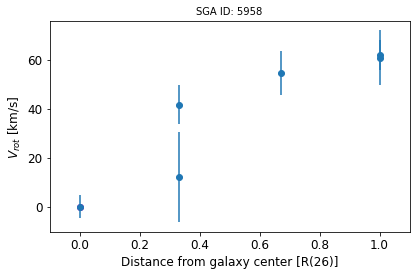

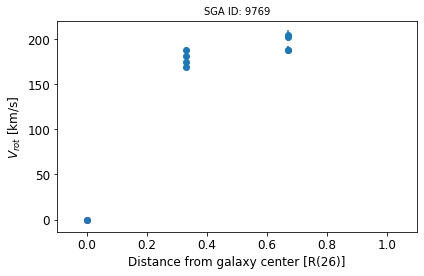

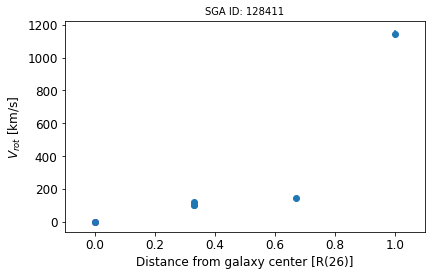

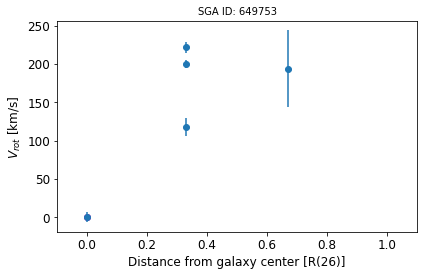

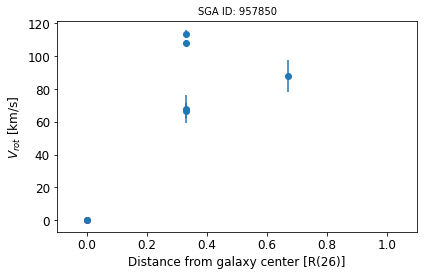

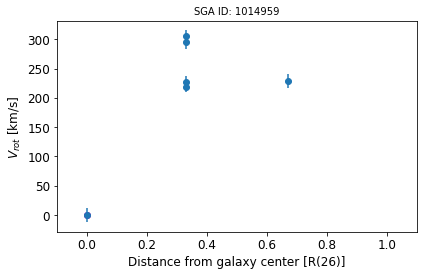

In [35]:
plot_graphs(inspectSix)
# It looks like 128411 might have an outlier right at the end which is heavily affecting the plot

In [86]:
#Taken from KADGLAS dark_matter_mass_v1.py

def rot_fit_tanh(radius, params):
    """
    Function to fit the rotation curve data to.
    PARAMETERS
    ==========
    
    radius : float
        radius of given data point
    v_max : float
        The maximum velocity (or in the case of fitting the negative, the
        absolute value of the minimum velocity) parameter of the rotation curve 
        equation
    r_turn : float
        The radius at which the rotation curve trasitions from increasing to 
        flat-body for the rotation curve equation (given in kpc)
    RETURNS
    =======
        
    The rotation curve equation with the given '@param' parameters and
    'radius' data
    """

    v_max, r_turn = params

    return v_max * np.tanh(radius/r_turn)


In [263]:
def loglikelihood(params, radius, v_rot, v_rot_err):
    
    v = rot_fit_tanh(radius, params)
    v[v <= 0] = np.finfo( dtype=np.float64).tiny
        
    return -0.5*np.sum( ((v_rot - v)/v_rot_err)**2 + np.log(2*np.pi*v_rot_err**2))

def neg_loglikelihood(params, radius, v_rot, v_rot_err):
    return (-1)*loglikelihood(params, radius, v_rot, v_rot_err)
    

In [287]:
v_max_bounds = (10,2000)
r_turn_bounds =(0.01,1)

rot_param_bounds = [v_max_bounds, r_turn_bounds]

In [293]:
#scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

def fit_data(data, fit_func):
    
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)
    
    results_SGA_dictionary = {}

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)
            
            PV_SGA = data[data['SGA_ID']==sga_gal]
            
            dist_r26 = PV_SGA["SKY_TARGET_DIST_R26"]
            
            v_rot = np.abs(PV_SGA["V_ROT_CORRECTED"])
                           
            v_rot_err = PV_SGA["V_ROT_CORRECTED_ERR"]
            
            #fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
            #ax.errorbar(dist_r26, v_rot, yerr=v_rot_err, fmt='.')
            
            results = None

            for i in range(10):
                x0 = [np.random.uniform(a[0], a[-1]) for a in rot_param_bounds]
                result = minimize(fit_func, x0, method = 'L-BFGS-B', 
                                  args = (dist_r26, v_rot, v_rot_err), bounds = rot_param_bounds)
                
                if result.success:

                    if results is None:
                        results = result
                    else:
                        if result.fun < results.fun:
                            results = result
            
            results_SGA_dictionary[sga_gal] = results
                            
    return results_SGA_dictionary

In [294]:
results_SGA_dictionary = fit_data(inspectSix,neg_loglikelihood)

  0%|          | 0/6 [00:00<?, ?it/s]

In [295]:
results_SGA_dictionary[5958].x

array([63.85119224,  0.50340355])

In [296]:
def plot_graphs(data):
    """
    Plot the graphs for a given data table
    
    Parameters
    ----------
    data : astropy.Table
    
    """
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)
            
            PV_SGA = data[data['SGA_ID']==sga_gal]
            plt.figure()
            plt.title(f"SGA ID: {sga_gal}")
            plt.xlim((-0.1, 1.1))
            plt.xlabel('Distance from galaxy center [R(26)]')
            plt.ylabel('$V_{rot}$ [km/s]')
            plt.tight_layout()
            plt.plot(0,0, "mo")
            plt.errorbar(PV_SGA['SKY_TARGET_DIST_R26'], np.abs(PV_SGA['V_ROT_CORRECTED']), yerr=PV_SGA['V_ROT_CORRECTED_ERR'].data, fmt='o')
            
            # Plot the model on a dense grid of r/R26
            r = np.arange(0, 1, 0.01)
            vmax, rturn = results_SGA_dictionary[sga_gal].x
            chi2 = results_SGA_dictionary[sga_gal].fun
            plt.plot(r, rot_fit_tanh(r, [vmax, rturn]), 
                     label=rf'$V_\mathrm{{max}}={vmax:.2f}$, $r_\mathrm{{turn}}={rturn:.2f}$, $\chi^2={chi2:.2f}$')
            plt.legend(loc='best')
            
            # plt.plot(PV_SGA['SKY_TARGET_DIST_R26'], rot_fit_tanh(PV_SGA['SKY_TARGET_DIST_R26'], results_SGA_dictionary[sga_gal].x))

  0%|          | 0/6 [00:00<?, ?it/s]

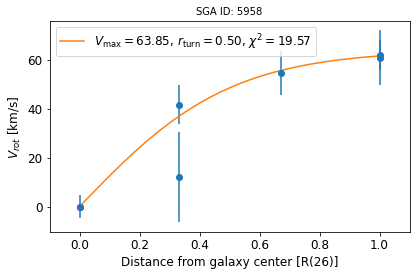

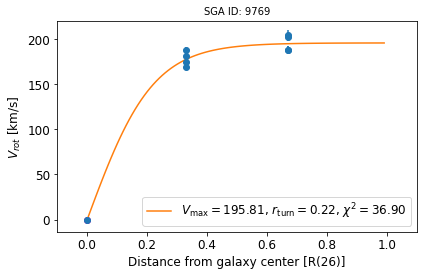

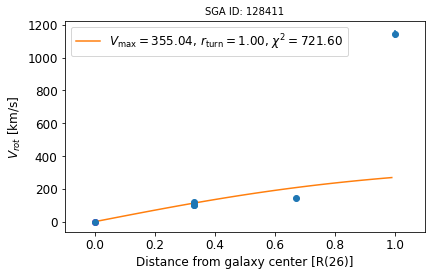

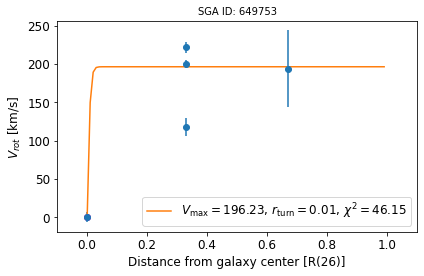

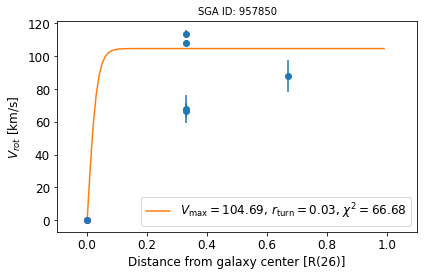

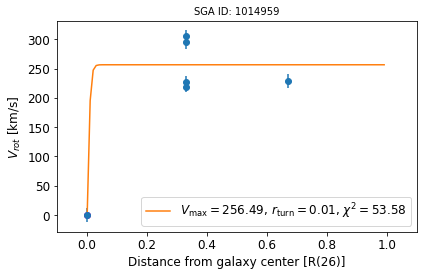

In [297]:
plot_graphs(inspectSix)

In [ ]:
def plotCheckZwarn(data):
    """
    Plot the graphs for a given data table
    
    Parameters
    ----------
    data : astropy.Table
    
    """
    # Setup for progress bar
    sga_gal = np.unique(data['SGA_ID'])
    N = len(sga_gal)

    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_gal in enumerate(sga_gal):
            progress_bar.update(1)
            
            PV_SGA = data[data['SGA_ID']==sga_gal]
            plt.figure()
            plt.title(f"SGA ID: {sga_gal}")
            plt.xlim((-0.1, 1.1))
            plt.xlabel('Distance from galaxy center [R(26)]')
            plt.ylabel('$V_{rot}$ [km/s]')
            plt.tight_layout()
            plt.plot(0,0, "mo")
            if PV_SGA[PV_SGA['ZWARN'] == 0]:
                plt.errorbar(PV_SGA['SKY_TARGET_DIST_R26'], np.abs(PV_SGA['V_ROT_CORRECTED']), yerr=PV_SGA['V_ROT_CORRECTED_ERR'].data, fmt='bo')
            else:
                  plt.errorbar(PV_SGA['SKY_TARGET_DIST_R26'], np.abs(PV_SGA['V_ROT_CORRECTED']), yerr=PV_SGA['V_ROT_CORRECTED_ERR'].data, fmt='ro')
                